# Train SqueezeNet v1.1 network to classify normal cervix images

In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

In [2]:
import os
from datetime import datetime
from glob import glob
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Project
import sys
sys.path.append(os.path.join(os.path.abspath(os.path.dirname('.')), '..', 'common'))

In [4]:
import matplotlib.pylab as plt
%matplotlib inline

def plt_st(n, m):
    plt.figure(figsize=(n, m))

In [5]:
sys.path.append(os.path.join(os.path.abspath(os.path.dirname('.')), '..', 'common/KerasSqueezeNet'))
from keras_squeezenet.squeezenet import SqueezeNet

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GT 750M (CNMeM is enabled with initial size: 50.0% of memory, cuDNN 5110)


In [6]:
model = SqueezeNet(input_shape=(299, 299, 3), classes=3, include_top=False)
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 299, 299, 3)   0                                            
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 149, 149, 64)  1792                                         
____________________________________________________________________________________________________
relu_conv1 (Activation)          (None, 149, 149, 64)  0                                            
____________________________________________________________________________________________________
pool1 (MaxPooling2D)             (None, 74, 74, 64)    0                                            
___________________________________________________________________________________________

In [61]:
from data_utils import GENERATED_DATA
print("\n {} - Get train/val lists ...".format(datetime.now()))

trainval_normal_id_type_list = np.load(os.path.join(GENERATED_DATA, 'normal_id_type_list.npz'))['normal_id_type_list'].astype(np.str)
len(trainval_normal_id_type_list), trainval_normal_id_type_list[0]


 2017-05-12 23:25:35.965004 - Get train/val lists ...


(4977, array(['209', 'AType_2'], 
       dtype='<U7'))

In [62]:
def repeat(id_type_list, output_size):
    n = int(np.ceil(output_size * 1.0 / len(id_type_list)))    
    out = np.tile(id_type_list, [n, 1])
    return out[:output_size]


def generate_trainval_kfolds(id_type_list, n_folds, seed):    
    types = (('Type_1', 'AType_1'), ('Type_2', 'AType_2'), ('Type_3', 'AType_3'))
    out = [None, None, None]
    for i, ts in enumerate(types):
        o = id_type_list[(id_type_list[:, 1] == ts[0]) | (id_type_list[:, 1] == ts[1])]
        out[i] = o

    ll = max([len(o) for o in out])
    out = np.array([repeat(o, ll) for o in out])
    out = out.reshape((3 * ll, 2))  
    np.random.seed(seed)
    np.random.shuffle(out)

    for val_fold_index in range(n_folds):
        ll = len(out)
        size = int(ll * 1.0 / n_folds + 1.0)
        overlap = (size * n_folds - ll) * 1.0 / (n_folds - 1.0)
        val_start = int(round(val_fold_index * (size - overlap)))
        val_end = val_start + size

        val_id_type_list = out[val_start:val_end]    
        train_id_type_list = np.array([
                [i[0], i[1]] for i in out if np.sum(np.prod(i == val_id_type_list, axis=1)) == 0
        ])
        yield train_id_type_list, val_id_type_list

In [63]:
def compute_type_distribution(id_type_list):
    types = (('Type_1', 'AType_1'), ('Type_2', 'AType_2'), ('Type_3', 'AType_3'))
    ll = len(id_type_list)
    out = [0.0, 0.0, 0.0]
    for i, ts in enumerate(types):
        for t in ts:
            out[i] += (id_type_list[:, 1] == t).sum()        
        out[i] *= 1.0 / ll
    return out

def to_set(id_type_array):
    return set([(i[0], i[1]) for i in id_type_array.tolist()])

In [64]:
from xy_providers import DataCache
try:
    if cache is None:
        cache = DataCache(0)
except NameError:
    cache = DataCache(0)

In [65]:
from training_utils import exp_decay, step_decay

# lr = 0.001
# decay = 0.01
# iterations = np.arange(50)
# lr2 = lr * (1. / (1. + decay * iterations))
# lr2

In [66]:
from keras import backend as K

def precision(y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

In [102]:
from training_utils import find_best_weights_file2
from imagery_classification.normal_types_classification import classification_train as train
from keras.optimizers import Adadelta, Adam, SGD

seed = 2017

optimizer = 'adam'
lr_base = 0.00001

nb_epochs = 50
batch_size = 8

load_best_weights = False

names_to_train=[            
    'fire5/squeeze1x1',  'fire5/expand1x1',     'fire5/expand3x3',    
    'fire6/squeeze1x1',  'fire6/expand1x1',     'fire6/expand3x3',    
    'fire7/squeeze1x1',  'fire7/expand1x1',     'fire7/expand3x3',    
    'fire8/squeeze1x1',  'fire8/expand1x1',     'fire8/expand3x3',    
    'fire9/squeeze1x1',  'fire9/expand1x1',     'fire9/expand3x3',
    'conv10',
]


# Iterate over folds
n_folds = 6
val_fold_index = 0
hists = []

for  train_id_type_list, val_id_type_list in generate_trainval_kfolds(trainval_normal_id_type_list, n_folds, seed=seed):

    save_prefix='squeezenet_v2_cervix_normal_cvfold=%i_opt=%s_seed=%i' % (val_fold_index, optimizer, seed)
    print("\n\n ---- Validation fold index: ", val_fold_index, "/", n_folds)
    val_fold_index += 1

    print(len(train_id_type_list), len(val_id_type_list))
    assert len(to_set(train_id_type_list) & to_set(val_id_type_list)) == 0, "WTF"
    print(compute_type_distribution(train_id_type_list))
    print(compute_type_distribution(val_id_type_list))

    print("\n {} - Get SqueezeNet v1.1 model ...".format(datetime.now()))
    cnn = SqueezeNet(input_shape=(299, 299, 3), classes=3, include_top=False)

    if names_to_train is None:
        for layer in cnn.layers:
            if layer.name in names_to_train:
                layer.trainable = True
            else:
                layer.trainable = False

    if optimizer == 'adadelta':
        opt = Adadelta(lr=lr_base)
    elif optimizer == 'adam':
        opt = Adam(lr=lr_base)
    elif optimizer == 'sgd':
        opt = SGD(lr=lr_base, momentum=0.9, decay=0.00001, nesterov=True)
    else:
        raise Exception("Optimizer '%s' is unknown" % optimizer)
    cnn.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', precision, recall])
    
    if load_best_weights:
        weights_files = glob("weights/%s*.h5" % save_prefix)
        if len(weights_files) > 0:
            best_weights_filename, best_val_loss = find_best_weights_file2(weights_files, field_name='val_loss')
            print("Load best loss weights: ", best_weights_filename, best_val_loss)
            cnn.load_weights(best_weights_filename)
        
#     lrate_decay_f = lambda epoch: step_decay(epoch, lr=lr_base, base=2.0, period=7) 
    lrate_decay_f = lambda epoch: exp_decay(epoch, lr=lr_base, a=0.935) 
#     lrate_decay_f = None
    
    np.random.seed(seed)
    print("\n {} - Start training ...".format(datetime.now()))
    h = train(cnn, 
              train_id_type_list, 
              val_id_type_list, 
              option='cervix',
              normalization='vgg',
              nb_epochs=nb_epochs,
              samples_per_epoch=1.0 * len(train_id_type_list),
              nb_val_samples=len(val_id_type_list),
              lrate_decay_f=lrate_decay_f,
              batch_size=batch_size,
              xy_provider_cache=cache,
              image_size=(299, 299),
              seed=seed,
              save_prefix=save_prefix)
    if h is None:
        break
    hists.append(h)

[autoreload of visu_utils failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.5/site-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
  File "/Users/vfomin/Documents/ML/Kaggle/Intel_MobileODT/notebooks/../common/visu_utils.py", line 107
    heatmap[] -=
            ^
SyntaxError: invalid syntax
]




 ---- Validation fold index:  0 / 6
5470 1249
[0.29945155393053019, 0.38117001828153568, 0.31937842778793418]
[0.32265812650120096, 0.32906325060048036, 0.34827862289831862]

 2017-05-13 19:35:50.581615 - Get SqueezeNet v1.1 model ...

 2017-05-13 19:35:52.748146 - Start training ...

-- Training parameters: 8, 50, 5472, 1256
Image normalization:  vgg

-- Fit model
- New Keras API found -
Epoch 1/50
684/684 [==============================] - 529s - loss: 1.0948 - acc: 0.4368 - precision: 0.4762 - recall: 0.1707 - val_loss: 0.9979 - val_acc: 0.5111 - val_precision: 0.5821 - val_recall: 0.1720
Epoch 2/50
684/684 [==============================] - 529s - loss: 0.9798 - acc: 0.5062 - precision: 0.5868 - recall: 0.2873 - val_loss: 0.9484 - val_acc: 0.5151 - val_precision: 0.6326 - val_recall: 0.3495
Epoch 3/50
684/684 [==============================] - 527s - loss: 0.9456 - acc: 0.5466 - precision: 0.6182 - recall: 0.3543 - val_loss: 0.9075 - val_acc: 0.5844 - val_precision: 0.6684 - val_

In [103]:
hists

In [104]:
from training_utils import find_best_weights_file2

val_fold_index = 0
optimizer = 'adam'
seed = 2017
load_best_weights = True

save_prefix='squeezenet_v2_cervix_normal_cvfold=%i_opt=%s_seed=%i' % (val_fold_index, optimizer, seed)
cnn = SqueezeNet(input_shape=(299, 299, 3), classes=3, include_top=False)

if load_best_weights:
    weights_files = glob("weights/%s*.h5" % save_prefix)
    if len(weights_files) > 0:
        best_weights_filename, best_val_loss = find_best_weights_file2(weights_files, field_name='val_loss')
        print("Load best loss weights: ", best_weights_filename, best_val_loss)
        cnn.load_weights(best_weights_filename)

Load best loss weights:  weights/squeezenet_v2_cervix_normal_cvfold=0_opt=adam_seed=2017_38_val_loss=0.8098_val_acc=0.6457_val_precision=0.7188_val_recall=0.5382.h5 0.8098


In [105]:
batch_size = 1
from data_utils import GENERATED_DATA
from image_utils import scale_percentile
from xy_providers import cached_image_label_provider
from preprocessing.image.generators import ImageDataGenerator

normalize_data = True
image_size = (299, 299)
channels_first = False

xy_provider = cached_image_label_provider
val_gen = ImageDataGenerator(featurewise_center=normalize_data,
                             featurewise_std_normalization=normalize_data)

if normalize_data:
    val_gen.std = 1.0 / 255.0  # Rescale to [0.0, 255.0]
    m = np.array([123.68, 116.779, 103.939]) / 255.0 # RGB
    if channels_first:                
        m = m[:, None, None]
    else:
        m = m[None, None, :]
    val_gen.mean = m   
        
          
flow = val_gen.flow(xy_provider(val_id_type_list,
                                image_size=image_size,
                                channels_first=channels_first,
                                cache=cache,
                                test_mode=True),
                    # Ensure that all batches have the same size
                    len(val_id_type_list),
                    batch_size=batch_size)
total_counter = 0

In [108]:
from visu_utils import compute_heatmap
_to_data_format = lambda image : image
if channels_first:
    _to_data_format = lambda image : image.transpose([1, 2, 0])

-- 18
('896', 'AType_2') [ 0.22591285  0.49688327  0.27720392] [0 1 0]
y_pred_0= [[ 0.22591285  0.49688327  0.27720392]]
top_class_indices= [1 2 0]


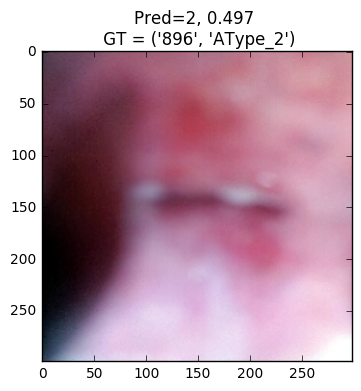

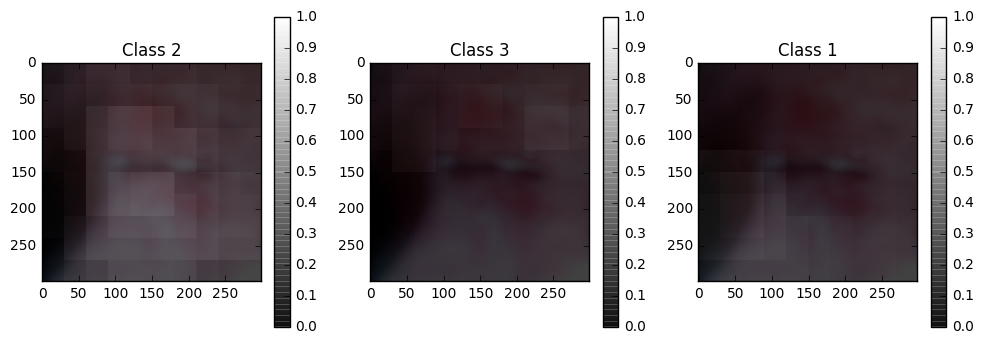

In [125]:
for x, y_true, info in flow:

    s = y_true.shape[0]

    y_pred = cnn.predict(x)
    print("--", total_counter*batch_size + s)    
    total_counter += 1
    plt_st(12, 4)
    for i in range(s):
        print(info[i], y_pred[i], y_true[i])
        plt.subplot(1, s, i+1)
        plt.title("Pred={}, {:.3f} \n GT = {}".format(np.argmax(y_pred[i])+1, np.max(y_pred[i]), info[i]))
        plt.imshow(scale_percentile(_to_data_format(x[i, :, :, :])))

    n_classes = y_true.shape[1]
    plt_st(12, 4)
    for i in range(s):
        hm, top_class_indices = compute_heatmap(cnn, x[i, :, :, :], mask_size=60, step=30, n_top_classes=None, batch_size=16)        
        for j in range(n_classes):
            plt.subplot(s, n_classes, n_classes * i + j + 1)            
            plt.title("Class {}".format(top_class_indices[j] + 1))
            plt.imshow(scale_percentile(_to_data_format(x[i, :, :, :])))        
            plt.imshow(hm[j, :, :], alpha=0.75, cmap='gray', vmin=0, vmax=1)
            plt.colorbar()

    break

## Logs



seed = 2017

optimizer = 'adam'
lr_base = 0.00001

nb_epochs = 50
batch_size = 8

load_best_weights = False

```
names_to_train=[            
    'fire5/squeeze1x1',  'fire5/expand1x1',     'fire5/expand3x3',    
    'fire6/squeeze1x1',  'fire6/expand1x1',     'fire6/expand3x3',    
    'fire7/squeeze1x1',  'fire7/expand1x1',     'fire7/expand3x3',    
    'fire8/squeeze1x1',  'fire8/expand1x1',     'fire8/expand3x3',    
    'fire9/squeeze1x1',  'fire9/expand1x1',     'fire9/expand3x3',
    'conv10',
]
```


```
---- Validation fold index:  0 / 6
5470 1249
[0.29945155393053019, 0.38117001828153568, 0.31937842778793418]
[0.32265812650120096, 0.32906325060048036, 0.34827862289831862]

 2017-05-13 19:35:50.581615 - Get SqueezeNet v1.1 model ...

 2017-05-13 19:35:52.748146 - Start training ...

-- Training parameters: 8, 50, 5472, 1256
Image normalization:  vgg

-- Fit model
- New Keras API found -
Epoch 1/50
684/684 [] - 529s - loss: 1.0948 - acc: 0.4368 - precision: 0.4762 - recall: 0.1707 - val_loss: 0.9979 - val_acc: 0.5111 - val_precision: 0.5821 - val_recall: 0.1720
Epoch 2/50
684/684 [] - 529s - loss: 0.9798 - acc: 0.5062 - precision: 0.5868 - recall: 0.2873 - val_loss: 0.9484 - val_acc: 0.5151 - val_precision: 0.6326 - val_recall: 0.3495
Epoch 3/50
684/684 [] - 527s - loss: 0.9456 - acc: 0.5466 - precision: 0.6182 - recall: 0.3543 - val_loss: 0.9075 - val_acc: 0.5844 - val_precision: 0.6684 - val_recall: 0.3790
Epoch 4/50
684/684 [] - 527s - loss: 0.9272 - acc: 0.5662 - precision: 0.6315 - recall: 0.3748 - val_loss: 0.9174 - val_acc: 0.5748 - val_precision: 0.6675 - val_recall: 0.3392
Epoch 5/50
684/684 [] - 527s - loss: 0.9156 - acc: 0.5643 - precision: 0.6342 - recall: 0.3918 - val_loss: 0.9239 - val_acc: 0.5669 - val_precision: 0.6448 - val_recall: 0.3734
Epoch 6/50
684/684 [] - 527s - loss: 0.9138 - acc: 0.5689 - precision: 0.6289 - recall: 0.3995 - val_loss: 0.8934 - val_acc: 0.5860 - val_precision: 0.6860 - val_recall: 0.3965
Epoch 7/50
684/684 [] - 527s - loss: 0.8987 - acc: 0.5797 - precision: 0.6421 - recall: 0.4099 - val_loss: 0.9314 - val_acc: 0.5573 - val_precision: 0.6242 - val_recall: 0.4061
Epoch 8/50
684/684 [] - 527s - loss: 0.8938 - acc: 0.5828 - precision: 0.6504 - recall: 0.4205 - val_loss: 0.8520 - val_acc: 0.6083 - val_precision: 0.6768 - val_recall: 0.4514
Epoch 9/50
684/684 [] - 527s - loss: 0.8923 - acc: 0.5819 - precision: 0.6561 - recall: 0.4317 - val_loss: 0.8936 - val_acc: 0.5892 - val_precision: 0.6827 - val_recall: 0.4100
Epoch 10/50
684/684 [] - 527s - loss: 0.8833 - acc: 0.5905 - precision: 0.6605 - recall: 0.4353 - val_loss: 0.8722 - val_acc: 0.6210 - val_precision: 0.6901 - val_recall: 0.4355
Epoch 11/50
684/684 [] - 527s - loss: 0.8809 - acc: 0.5932 - precision: 0.6526 - recall: 0.4391 - val_loss: 0.8743 - val_acc: 0.5932 - val_precision: 0.6781 - val_recall: 0.4530
Epoch 12/50
684/684 [] - 527s - loss: 0.8684 - acc: 0.5992 - precision: 0.6617 - recall: 0.4461 - val_loss: 0.8746 - val_acc: 0.6051 - val_precision: 0.6711 - val_recall: 0.4697
Epoch 13/50
684/684 [] - 527s - loss: 0.8706 - acc: 0.5980 - precision: 0.6583 - recall: 0.4574 - val_loss: 0.8559 - val_acc: 0.6043 - val_precision: 0.6889 - val_recall: 0.4801
Epoch 14/50
684/684 [] - 527s - loss: 0.8741 - acc: 0.5980 - precision: 0.6612 - recall: 0.4521 - val_loss: 0.8676 - val_acc: 0.5963 - val_precision: 0.6886 - val_recall: 0.4482
Epoch 15/50
684/684 [] - 528s - loss: 0.8623 - acc: 0.6031 - precision: 0.6650 - recall: 0.4529 - val_loss: 0.8656 - val_acc: 0.5987 - val_precision: 0.6633 - val_recall: 0.4777
Epoch 16/50
684/684 [] - 528s - loss: 0.8568 - acc: 0.5969 - precision: 0.6701 - recall: 0.4673 - val_loss: 0.8633 - val_acc: 0.5844 - val_precision: 0.6417 - val_recall: 0.4602
Epoch 17/50
684/684 [] - 528s - loss: 0.8524 - acc: 0.6027 - precision: 0.6709 - recall: 0.4750 - val_loss: 0.8501 - val_acc: 0.6043 - val_precision: 0.6845 - val_recall: 0.4833
Epoch 18/50
684/684 [] - 528s - loss: 0.8457 - acc: 0.6102 - precision: 0.6728 - recall: 0.4777 - val_loss: 0.8542 - val_acc: 0.6083 - val_precision: 0.6666 - val_recall: 0.4952
Epoch 19/50
684/684 [] - 528s - loss: 0.8479 - acc: 0.6113 - precision: 0.6792 - recall: 0.4839 - val_loss: 0.8925 - val_acc: 0.5836 - val_precision: 0.6457 - val_recall: 0.4689
Epoch 20/50
684/684 [] - 532s - loss: 0.8501 - acc: 0.6080 - precision: 0.6713 - recall: 0.4834 - val_loss: 0.8483 - val_acc: 0.6186 - val_precision: 0.6955 - val_recall: 0.4666
Epoch 21/50
684/684 [] - 546s - loss: 0.8455 - acc: 0.6153 - precision: 0.6770 - recall: 0.4792 - val_loss: 0.8443 - val_acc: 0.6162 - val_precision: 0.6714 - val_recall: 0.5024
Epoch 22/50
684/684 [] - 631s - loss: 0.8437 - acc: 0.6095 - precision: 0.6731 - recall: 0.4779 - val_loss: 0.8515 - val_acc: 0.6099 - val_precision: 0.6802 - val_recall: 0.4705
Epoch 23/50
684/684 [] - 603s - loss: 0.8412 - acc: 0.6149 - precision: 0.6728 - recall: 0.4841 - val_loss: 0.8476 - val_acc: 0.6298 - val_precision: 0.6912 - val_recall: 0.4889
Epoch 24/50
684/684 [] - 583s - loss: 0.8410 - acc: 0.6106 - precision: 0.6677 - recall: 0.4890 - val_loss: 0.8482 - val_acc: 0.6115 - val_precision: 0.6921 - val_recall: 0.4713
Epoch 25/50
684/684 [] - 571s - loss: 0.8353 - acc: 0.6192 - precision: 0.6814 - recall: 0.4814 - val_loss: 0.8567 - val_acc: 0.6075 - val_precision: 0.6696 - val_recall: 0.4904
Epoch 26/50
684/684 [] - 569s - loss: 0.8355 - acc: 0.6155 - precision: 0.6739 - recall: 0.4934 - val_loss: 0.8289 - val_acc: 0.6266 - val_precision: 0.6870 - val_recall: 0.5072
Epoch 27/50
684/684 [] - 579s - loss: 0.8338 - acc: 0.6213 - precision: 0.6867 - recall: 0.4993 - val_loss: 0.8376 - val_acc: 0.6146 - val_precision: 0.6820 - val_recall: 0.4992
Epoch 28/50
684/684 [] - 550s - loss: 0.8329 - acc: 0.6179 - precision: 0.6828 - recall: 0.4894 - val_loss: 0.8525 - val_acc: 0.6226 - val_precision: 0.6765 - val_recall: 0.5008
Epoch 29/50
684/684 [] - 541s - loss: 0.8312 - acc: 0.6170 - precision: 0.6788 - recall: 0.4989 - val_loss: 0.8450 - val_acc: 0.6258 - val_precision: 0.6847 - val_recall: 0.5056
Epoch 30/50
684/684 [] - 531s - loss: 0.8264 - acc: 0.6219 - precision: 0.6779 - recall: 0.4978 - val_loss: 0.8303 - val_acc: 0.6274 - val_precision: 0.6916 - val_recall: 0.5080
Epoch 31/50
684/684 [] - 544s - loss: 0.8291 - acc: 0.6261 - precision: 0.6798 - recall: 0.5005 - val_loss: 0.8290 - val_acc: 0.6274 - val_precision: 0.6863 - val_recall: 0.5040
Epoch 32/50
684/684 [] - 551s - loss: 0.8307 - acc: 0.6179 - precision: 0.6808 - recall: 0.4921 - val_loss: 0.8545 - val_acc: 0.6170 - val_precision: 0.6737 - val_recall: 0.5096
Epoch 33/50
684/684 [] - 557s - loss: 0.8199 - acc: 0.6274 - precision: 0.6893 - recall: 0.5062 - val_loss: 0.8271 - val_acc: 0.6154 - val_precision: 0.6802 - val_recall: 0.5032
Epoch 34/50
684/684 [] - 541s - loss: 0.8281 - acc: 0.6213 - precision: 0.6821 - recall: 0.5084 - val_loss: 0.8475 - val_acc: 0.6242 - val_precision: 0.6700 - val_recall: 0.4960
Epoch 35/50
684/684 [] - 562s - loss: 0.8218 - acc: 0.6255 - precision: 0.6809 - recall: 0.5013 - val_loss: 0.8432 - val_acc: 0.6298 - val_precision: 0.6786 - val_recall: 0.5191
Epoch 36/50
684/684 [] - 556s - loss: 0.8236 - acc: 0.6336 - precision: 0.6853 - recall: 0.5093 - val_loss: 0.8315 - val_acc: 0.6258 - val_precision: 0.6731 - val_recall: 0.5064
Epoch 37/50
684/684 [] - 567s - loss: 0.8222 - acc: 0.6298 - precision: 0.6831 - recall: 0.5055 - val_loss: 0.8610 - val_acc: 0.6139 - val_precision: 0.6628 - val_recall: 0.5056
Epoch 38/50
684/684 [] - 564s - loss: 0.8305 - acc: 0.6204 - precision: 0.6787 - recall: 0.4965 - val_loss: 0.8468 - val_acc: 0.6194 - val_precision: 0.6691 - val_recall: 0.5032
Epoch 39/50
684/684 [] - 553s - loss: 0.8156 - acc: 0.6307 - precision: 0.6861 - recall: 0.5177 - val_loss: 0.8098 - val_acc: 0.6457 - val_precision: 0.7188 - val_recall: 0.5382
Epoch 40/50
684/684 [] - 558s - loss: 0.8197 - acc: 0.6294 - precision: 0.6850 - recall: 0.5102 - val_loss: 0.8545 - val_acc: 0.6107 - val_precision: 0.6662 - val_recall: 0.5040
Epoch 41/50
684/684 [] - 551s - loss: 0.8239 - acc: 0.6283 - precision: 0.6882 - recall: 0.5095 - val_loss: 0.8281 - val_acc: 0.6226 - val_precision: 0.6821 - val_recall: 0.5199
Epoch 42/50
684/684 [] - 570s - loss: 0.8245 - acc: 0.6226 - precision: 0.6856 - recall: 0.5073 - val_loss: 0.8356 - val_acc: 0.6258 - val_precision: 0.6798 - val_recall: 0.5215
Epoch 43/50
684/684 [] - 539s - loss: 0.8224 - acc: 0.6228 - precision: 0.6777 - recall: 0.5108 - val_loss: 0.8432 - val_acc: 0.6107 - val_precision: 0.6708 - val_recall: 0.4896
Epoch 44/50
684/684 [] - 531s - loss: 0.8219 - acc: 0.6283 - precision: 0.6788 - recall: 0.5086 - val_loss: 0.8383 - val_acc: 0.6290 - val_precision: 0.6923 - val_recall: 0.5096
Epoch 45/50
684/684 [] - 531s - loss: 0.8159 - acc: 0.6265 - precision: 0.6893 - recall: 0.5099 - val_loss: 0.8454 - val_acc: 0.6242 - val_precision: 0.6846 - val_recall: 0.5255
Epoch 46/50
684/684 [] - 530s - loss: 0.8202 - acc: 0.6210 - precision: 0.6780 - recall: 0.5095 - val_loss: 0.8212 - val_acc: 0.6369 - val_precision: 0.6970 - val_recall: 0.5430
Epoch 47/50
684/684 [] - 530s - loss: 0.8244 - acc: 0.6259 - precision: 0.6777 - recall: 0.5137 - val_loss: 0.8221 - val_acc: 0.6361 - val_precision: 0.7047 - val_recall: 0.5287
Epoch 48/50
684/684 [] - 530s - loss: 0.8196 - acc: 0.6318 - precision: 0.6913 - recall: 0.5174 - val_loss: 0.8420 - val_acc: 0.6234 - val_precision: 0.6765 - val_recall: 0.5159
Epoch 49/50
684/684 [] - 531s - loss: 0.8228 - acc: 0.6281 - precision: 0.6879 - recall: 0.5106 - val_loss: 0.8428 - val_acc: 0.6210 - val_precision: 0.6954 - val_recall: 0.5127
Epoch 50/50
684/684 [] - 531s - loss: 0.8165 - acc: 0.6257 - precision: 0.6884 - recall: 0.5090 - val_loss: 0.8223 - val_acc: 0.6369 - val_precision: 0.6962 - val_recall: 0.5247


 ---- Validation fold index:  1 / 6
5457 1249
[0.29356789444749865, 0.38409382444566614, 0.32233828110683527]
[0.34027221777421934, 0.32025620496397117, 0.33947157726180943]

 2017-05-14 03:10:16.490607 - Get SqueezeNet v1.1 model ...

 2017-05-14 03:10:18.537300 - Start training ...

-- Training parameters: 8, 50, 5464, 1256
Image normalization:  vgg

-- Fit model
- New Keras API found -
Epoch 1/50
683/683 [] - 531s - loss: 1.1156 - acc: 0.4429 - precision: 0.4682 - recall: 0.2042 - val_loss: 0.9807 - val_acc: 0.5382 - val_precision: 0.6056 - val_recall: 0.2667
Epoch 2/50
683/683 [] - 530s - loss: 0.9842 - acc: 0.5203 - precision: 0.5942 - recall: 0.2943 - val_loss: 0.9468 - val_acc: 0.5597 - val_precision: 0.6455 - val_recall: 0.3041
Epoch 3/50
683/683 [] - 530s - loss: 0.9584 - acc: 0.5368 - precision: 0.6038 - recall: 0.3371 - val_loss: 0.9393 - val_acc: 0.5605 - val_precision: 0.6364 - val_recall: 0.3567
Epoch 4/50
683/683 [] - 531s - loss: 0.9422 - acc: 0.5415 - precision: 0.6193 - recall: 0.3611 - val_loss: 0.9217 - val_acc: 0.5828 - val_precision: 0.6741 - val_recall: 0.3248
Epoch 5/50
683/683 [] - 531s - loss: 0.9337 - acc: 0.5538 - precision: 0.6322 - recall: 0.3669 - val_loss: 0.9116 - val_acc: 0.5748 - val_precision: 0.6590 - val_recall: 0.3670
Epoch 6/50
683/683 [] - 530s - loss: 0.9241 - acc: 0.5578 - precision: 0.6281 - recall: 0.3849 - val_loss: 0.9188 - val_acc: 0.5748 - val_precision: 0.6577 - val_recall: 0.3814
Epoch 7/50
683/683 [] - 531s - loss: 0.9083 - acc: 0.5739 - precision: 0.6493 - recall: 0.4079 - val_loss: 0.9058 - val_acc: 0.5645 - val_precision: 0.6664 - val_recall: 0.4061
Epoch 8/50
683/683 [] - 531s - loss: 0.9050 - acc: 0.5617 - precision: 0.6402 - recall: 0.4111 - val_loss: 0.8890 - val_acc: 0.6051 - val_precision: 0.7123 - val_recall: 0.3726
Epoch 9/50
683/683 [] - 531s - loss: 0.8997 - acc: 0.5741 - precision: 0.6488 - recall: 0.4215 - val_loss: 0.9086 - val_acc: 0.5772 - val_precision: 0.6332 - val_recall: 0.4323
Epoch 10/50
683/683 [] - 531s - loss: 0.8957 - acc: 0.5752 - precision: 0.6485 - recall: 0.4231 - val_loss: 0.8895 - val_acc: 0.5987 - val_precision: 0.6756 - val_recall: 0.4419
Epoch 11/50
683/683 [] - 531s - loss: 0.8851 - acc: 0.5844 - precision: 0.6519 - recall: 0.4286 - val_loss: 0.8981 - val_acc: 0.5860 - val_precision: 0.6459 - val_recall: 0.4260
Epoch 12/50
683/683 [] - 532s - loss: 0.8786 - acc: 0.5946 - precision: 0.6647 - recall: 0.4515 - val_loss: 0.8843 - val_acc: 0.6003 - val_precision: 0.6702 - val_recall: 0.4355
Epoch 13/50
683/683 [] - 531s - loss: 0.8780 - acc: 0.5924 - precision: 0.6606 - recall: 0.4508 - val_loss: 0.8822 - val_acc: 0.6011 - val_precision: 0.6655 - val_recall: 0.4331
Epoch 14/50
683/683 [] - 528s - loss: 0.8776 - acc: 0.5853 - precision: 0.6656 - recall: 0.4429 - val_loss: 0.8948 - val_acc: 0.5947 - val_precision: 0.6543 - val_recall: 0.4459
Epoch 15/50
683/683 [] - 526s - loss: 0.8670 - acc: 0.6019 - precision: 0.6783 - recall: 0.4590 - val_loss: 0.8638 - val_acc: 0.6091 - val_precision: 0.6793 - val_recall: 0.4697
Epoch 16/50
683/683 [] - 526s - loss: 0.8664 - acc: 0.6019 - precision: 0.6729 - recall: 0.4652 - val_loss: 0.8904 - val_acc: 0.5900 - val_precision: 0.6611 - val_recall: 0.4371
Epoch 17/50
683/683 [] - 526s - loss: 0.8592 - acc: 0.6030 - precision: 0.6735 - recall: 0.4674 - val_loss: 0.8677 - val_acc: 0.6115 - val_precision: 0.6868 - val_recall: 0.4761
Epoch 18/50
683/683 [] - 527s - loss: 0.8611 - acc: 0.6008 - precision: 0.6674 - recall: 0.4658 - val_loss: 0.8713 - val_acc: 0.6075 - val_precision: 0.6711 - val_recall: 0.4841
Epoch 19/50
683/683 [] - 526s - loss: 0.8563 - acc: 0.6061 - precision: 0.6767 - recall: 0.4755 - val_loss: 0.8700 - val_acc: 0.6099 - val_precision: 0.6759 - val_recall: 0.4642
Epoch 20/50
683/683 [] - 526s - loss: 0.8542 - acc: 0.6083 - precision: 0.6708 - recall: 0.4676 - val_loss: 0.8638 - val_acc: 0.6067 - val_precision: 0.6852 - val_recall: 0.4904
Epoch 21/50
683/683 [] - 527s - loss: 0.8495 - acc: 0.6111 - precision: 0.6827 - recall: 0.4811 - val_loss: 0.8519 - val_acc: 0.6075 - val_precision: 0.6785 - val_recall: 0.4928
Epoch 22/50
683/683 [] - 525s - loss: 0.8450 - acc: 0.6094 - precision: 0.6795 - recall: 0.4938 - val_loss: 0.8972 - val_acc: 0.5653 - val_precision: 0.6407 - val_recall: 0.4331
Epoch 23/50
683/683 [] - 526s - loss: 0.8475 - acc: 0.6074 - precision: 0.6790 - recall: 0.4764 - val_loss: 0.8690 - val_acc: 0.6226 - val_precision: 0.6732 - val_recall: 0.4713
Epoch 24/50
683/683 [] - 525s - loss: 0.8459 - acc: 0.6160 - precision: 0.6799 - recall: 0.4868 - val_loss: 0.8575 - val_acc: 0.6083 - val_precision: 0.6875 - val_recall: 0.5143
Epoch 25/50
683/683 [] - 526s - loss: 0.8451 - acc: 0.6144 - precision: 0.6723 - recall: 0.4833 - val_loss: 0.8698 - val_acc: 0.6027 - val_precision: 0.6813 - val_recall: 0.4689
Epoch 26/50
683/683 [] - 527s - loss: 0.8422 - acc: 0.6146 - precision: 0.6792 - recall: 0.4872 - val_loss: 0.8659 - val_acc: 0.6115 - val_precision: 0.6677 - val_recall: 0.4713
Epoch 27/50
683/683 [] - 526s - loss: 0.8438 - acc: 0.6180 - precision: 0.6833 - recall: 0.4929 - val_loss: 0.8536 - val_acc: 0.6170 - val_precision: 0.6810 - val_recall: 0.4785
Epoch 28/50
683/683 [] - 525s - loss: 0.8450 - acc: 0.6177 - precision: 0.6882 - recall: 0.4892 - val_loss: 0.8688 - val_acc: 0.6059 - val_precision: 0.6601 - val_recall: 0.4586
Epoch 29/50
683/683 [] - 526s - loss: 0.8383 - acc: 0.6173 - precision: 0.6836 - recall: 0.4941 - val_loss: 0.8711 - val_acc: 0.6139 - val_precision: 0.6799 - val_recall: 0.4841
Epoch 30/50
683/683 [] - 526s - loss: 0.8388 - acc: 0.6162 - precision: 0.6894 - recall: 0.4894 - val_loss: 0.8647 - val_acc: 0.6099 - val_precision: 0.6741 - val_recall: 0.4881
Epoch 31/50
683/683 [] - 527s - loss: 0.8310 - acc: 0.6245 - precision: 0.6895 - recall: 0.5038 - val_loss: 0.8567 - val_acc: 0.6170 - val_precision: 0.6799 - val_recall: 0.4952
Epoch 32/50
683/683 [] - 526s - loss: 0.8378 - acc: 0.6146 - precision: 0.6833 - recall: 0.4967 - val_loss: 0.8740 - val_acc: 0.5979 - val_precision: 0.6692 - val_recall: 0.4674


 ---- Validation fold index:  2 / 6
5475 1249
[0.29278538812785387, 0.38009132420091324, 0.32712328767123289]
[0.34267413931144913, 0.33226581265012006, 0.32506004803843075]

 2017-05-14 07:52:31.485739 - Get SqueezeNet v1.1 model ...

 2017-05-14 07:52:33.362973 - Start training ...

-- Training parameters: 8, 50, 5480, 1256
Image normalization:  vgg

-- Fit model
- New Keras API found -
Epoch 1/50
685/685 [] - 528s - loss: 1.0960 - acc: 0.4131 - precision: 0.4480 - recall: 0.1743 - val_loss: 1.0272 - val_acc: 0.4793 - val_precision: 0.5434 - val_recall: 0.1943
Epoch 2/50
685/685 [] - 529s - loss: 0.9963 - acc: 0.4960 - precision: 0.5599 - recall: 0.2734 - val_loss: 0.9867 - val_acc: 0.5000 - val_precision: 0.6012 - val_recall: 0.2349
Epoch 3/50
685/685 [] - 530s - loss: 0.9585 - acc: 0.5296 - precision: 0.5927 - recall: 0.3380 - val_loss: 0.9683 - val_acc: 0.5175 - val_precision: 0.5923 - val_recall: 0.2619
Epoch 4/50
685/685 [] - 528s - loss: 0.9359 - acc: 0.5569 - precision: 0.6264 - recall: 0.3797 - val_loss: 0.9459 - val_acc: 0.5454 - val_precision: 0.6345 - val_recall: 0.3861
Epoch 5/50
685/685 [] - 528s - loss: 0.9124 - acc: 0.5741 - precision: 0.6363 - recall: 0.4164 - val_loss: 0.9242 - val_acc: 0.5788 - val_precision: 0.6700 - val_recall: 0.3225
Epoch 6/50
685/685 [] - 529s - loss: 0.9046 - acc: 0.5728 - precision: 0.6505 - recall: 0.4135 - val_loss: 0.9275 - val_acc: 0.5549 - val_precision: 0.6198 - val_recall: 0.4045
Epoch 7/50
685/685 [] - 529s - loss: 0.8999 - acc: 0.5737 - precision: 0.6501 - recall: 0.4261 - val_loss: 0.9230 - val_acc: 0.5581 - val_precision: 0.6528 - val_recall: 0.3734
Epoch 8/50
685/685 [] - 529s - loss: 0.8944 - acc: 0.5834 - precision: 0.6536 - recall: 0.4274 - val_loss: 0.8917 - val_acc: 0.5772 - val_precision: 0.6511 - val_recall: 0.3989
Epoch 9/50
685/685 [] - 529s - loss: 0.8794 - acc: 0.5918 - precision: 0.6524 - recall: 0.4405 - val_loss: 0.9206 - val_acc: 0.5621 - val_precision: 0.6307 - val_recall: 0.4554
Epoch 10/50
685/685 [] - 530s - loss: 0.8721 - acc: 0.5993 - precision: 0.6632 - recall: 0.4491 - val_loss: 0.9017 - val_acc: 0.5804 - val_precision: 0.6473 - val_recall: 0.4204
Epoch 11/50
685/685 [] - 529s - loss: 0.8727 - acc: 0.5971 - precision: 0.6628 - recall: 0.4493 - val_loss: 0.9023 - val_acc: 0.5740 - val_precision: 0.6482 - val_recall: 0.4188
Epoch 12/50
685/685 [] - 529s - loss: 0.8633 - acc: 0.6082 - precision: 0.6715 - recall: 0.4717 - val_loss: 0.9168 - val_acc: 0.5605 - val_precision: 0.6519 - val_recall: 0.4268
Epoch 13/50
685/685 [] - 528s - loss: 0.8519 - acc: 0.6119 - precision: 0.6772 - recall: 0.4765 - val_loss: 0.8965 - val_acc: 0.5979 - val_precision: 0.6566 - val_recall: 0.4570
Epoch 14/50
685/685 [] - 529s - loss: 0.8524 - acc: 0.6099 - precision: 0.6835 - recall: 0.4818 - val_loss: 0.8868 - val_acc: 0.5892 - val_precision: 0.6441 - val_recall: 0.4658
Epoch 15/50
685/685 [] - 529s - loss: 0.8544 - acc: 0.6144 - precision: 0.6697 - recall: 0.4788 - val_loss: 0.9023 - val_acc: 0.5844 - val_precision: 0.6317 - val_recall: 0.4769
Epoch 16/50
685/685 [] - 529s - loss: 0.8442 - acc: 0.6117 - precision: 0.6670 - recall: 0.4843 - val_loss: 0.8998 - val_acc: 0.5971 - val_precision: 0.6485 - val_recall: 0.4626
Epoch 17/50
685/685 [] - 529s - loss: 0.8456 - acc: 0.6175 - precision: 0.6786 - recall: 0.4850 - val_loss: 0.9043 - val_acc: 0.5788 - val_precision: 0.6286 - val_recall: 0.4769
Epoch 18/50
685/685 [] - 547s - loss: 0.8366 - acc: 0.6266 - precision: 0.6810 - recall: 0.5036 - val_loss: 0.8872 - val_acc: 0.5987 - val_precision: 0.6564 - val_recall: 0.4562
Epoch 19/50
685/685 [] - 546s - loss: 0.8367 - acc: 0.6195 - precision: 0.6880 - recall: 0.5036 - val_loss: 0.8885 - val_acc: 0.5971 - val_precision: 0.6351 - val_recall: 0.4602
Epoch 20/50
685/685 [] - 541s - loss: 0.8358 - acc: 0.6259 - precision: 0.6825 - recall: 0.4980 - val_loss: 0.9337 - val_acc: 0.5764 - val_precision: 0.6221 - val_recall: 0.4777
Epoch 21/50
685/685 [] - 543s - loss: 0.8275 - acc: 0.6257 - precision: 0.6838 - recall: 0.4965 - val_loss: 0.8602 - val_acc: 0.5955 - val_precision: 0.6731 - val_recall: 0.5024
Epoch 22/50
685/685 [] - 539s - loss: 0.8252 - acc: 0.6292 - precision: 0.6841 - recall: 0.5119 - val_loss: 0.8732 - val_acc: 0.5892 - val_precision: 0.6385 - val_recall: 0.4737
Epoch 23/50
685/685 [] - 566s - loss: 0.8259 - acc: 0.6292 - precision: 0.6833 - recall: 0.5066 - val_loss: 0.8717 - val_acc: 0.6123 - val_precision: 0.6791 - val_recall: 0.5056
Epoch 24/50
685/685 [] - 567s - loss: 0.8249 - acc: 0.6285 - precision: 0.6827 - recall: 0.5095 - val_loss: 0.9047 - val_acc: 0.5868 - val_precision: 0.6316 - val_recall: 0.4825
Epoch 25/50
685/685 [] - 549s - loss: 0.8259 - acc: 0.6210 - precision: 0.6806 - recall: 0.5077 - val_loss: 0.8601 - val_acc: 0.6035 - val_precision: 0.6636 - val_recall: 0.4936
Epoch 26/50
685/685 [] - 561s - loss: 0.8182 - acc: 0.6274 - precision: 0.6836 - recall: 0.5131 - val_loss: 0.8658 - val_acc: 0.5987 - val_precision: 0.6624 - val_recall: 0.4968
Epoch 27/50
309/685 [============>.................] - ETA: 285s - loss: 0.8212 - acc: 0.6294 - precision: 0.6893 - recall: 0.5097
```


----

seed = 2017

optimizer = 'sgd'
lr_base = 0.0001

nb_epochs = 50
batch_size = 8

load_best_weights = False
n_folds = 6


```
 ---- Validation fold index:  0 / 6
5470 1249
[0.29945155393053019, 0.38117001828153568, 0.31937842778793418]
[0.32265812650120096, 0.32906325060048036, 0.34827862289831862]

 2017-05-13 00:13:53.214533 - Get SqueezeNet v1.1 model ...

 2017-05-13 00:13:55.716897 - Start training ...

-- Training parameters: 8, 50, 5472, 1256
Image normalization:  vgg

-- Fit model
- New Keras API found -
Epoch 1/50
684/684 [] - 1548s - loss: 1.0126 - acc: 0.4892 - precision: 0.5291 - recall: 0.2246 - val_loss: 0.9567 - val_acc: 0.5470 - val_precision: 0.6219 - val_recall: 0.3432
Epoch 2/50
684/684 [] - 548s - loss: 0.9469 - acc: 0.5418 - precision: 0.6103 - recall: 0.3463 - val_loss: 0.9306 - val_acc: 0.5470 - val_precision: 0.6287 - val_recall: 0.4307
Epoch 3/50
684/684 [] - 558s - loss: 0.9284 - acc: 0.5640 - precision: 0.6242 - recall: 0.3739 - val_loss: 0.8912 - val_acc: 0.5939 - val_precision: 0.6637 - val_recall: 0.4124
Epoch 4/50
684/684 [] - 552s - loss: 0.9136 - acc: 0.5751 - precision: 0.6368 - recall: 0.3918 - val_loss: 0.8997 - val_acc: 0.5629 - val_precision: 0.6452 - val_recall: 0.4045
Epoch 5/50
684/684 [] - 530s - loss: 0.9006 - acc: 0.5731 - precision: 0.6433 - recall: 0.4092 - val_loss: 0.9711 - val_acc: 0.5183 - val_precision: 0.5590 - val_recall: 0.3822
Epoch 6/50
684/684 [] - 530s - loss: 0.8998 - acc: 0.5707 - precision: 0.6408 - recall: 0.4179 - val_loss: 0.8813 - val_acc: 0.5764 - val_precision: 0.6344 - val_recall: 0.4315
Epoch 7/50
684/684 [] - 528s - loss: 0.8867 - acc: 0.5844 - precision: 0.6490 - recall: 0.4333 - val_loss: 0.8984 - val_acc: 0.5788 - val_precision: 0.6230 - val_recall: 0.4578
Epoch 8/50
684/684 [] - 528s - loss: 0.8756 - acc: 0.5932 - precision: 0.6545 - recall: 0.4472 - val_loss: 0.8171 - val_acc: 0.6250 - val_precision: 0.6801 - val_recall: 0.5096
Epoch 9/50
684/684 [] - 528s - loss: 0.8711 - acc: 0.5894 - precision: 0.6562 - recall: 0.4472 - val_loss: 0.8672 - val_acc: 0.6019 - val_precision: 0.6954 - val_recall: 0.4666
Epoch 10/50
684/684 [] - 528s - loss: 0.8619 - acc: 0.6076 - precision: 0.6643 - recall: 0.4598 - val_loss: 0.8597 - val_acc: 0.6019 - val_precision: 0.6977 - val_recall: 0.4323
Epoch 11/50
684/684 [] - 528s - loss: 0.8592 - acc: 0.5978 - precision: 0.6554 - recall: 0.4587 - val_loss: 0.8635 - val_acc: 0.6178 - val_precision: 0.6652 - val_recall: 0.5159
Epoch 12/50
684/684 [] - 528s - loss: 0.8465 - acc: 0.6102 - precision: 0.6639 - recall: 0.4772 - val_loss: 0.8922 - val_acc: 0.5820 - val_precision: 0.6518 - val_recall: 0.4610
Epoch 13/50
684/684 [] - 528s - loss: 0.8452 - acc: 0.6120 - precision: 0.6644 - recall: 0.4841 - val_loss: 0.8132 - val_acc: 0.6433 - val_precision: 0.7115 - val_recall: 0.5311
Epoch 14/50
684/684 [] - 528s - loss: 0.8405 - acc: 0.6162 - precision: 0.6785 - recall: 0.4879 - val_loss: 0.8455 - val_acc: 0.6139 - val_precision: 0.6708 - val_recall: 0.4952
Epoch 15/50
684/684 [] - 528s - loss: 0.8350 - acc: 0.6054 - precision: 0.6615 - recall: 0.4850 - val_loss: 0.8590 - val_acc: 0.5963 - val_precision: 0.6227 - val_recall: 0.5104
Epoch 16/50
684/684 [] - 528s - loss: 0.8210 - acc: 0.6261 - precision: 0.6781 - recall: 0.5075 - val_loss: 0.8440 - val_acc: 0.6003 - val_precision: 0.6456 - val_recall: 0.5064
Epoch 17/50
684/684 [] - 528s - loss: 0.8226 - acc: 0.6193 - precision: 0.6772 - recall: 0.5007 - val_loss: 0.8149 - val_acc: 0.6186 - val_precision: 0.6929 - val_recall: 0.5040
Epoch 18/50
684/684 [] - 529s - loss: 0.8072 - acc: 0.6268 - precision: 0.6835 - recall: 0.5214 - val_loss: 0.8494 - val_acc: 0.6075 - val_precision: 0.6669 - val_recall: 0.5342
Epoch 19/50
684/684 [] - 529s - loss: 0.8091 - acc: 0.6376 - precision: 0.6821 - recall: 0.5227 - val_loss: 0.8588 - val_acc: 0.6019 - val_precision: 0.6622 - val_recall: 0.5279


 ---- Validation fold index:  1 / 6
5457 1249
[0.29356789444749865, 0.38409382444566614, 0.32233828110683527]
[0.34027221777421934, 0.32025620496397117, 0.33947157726180943]

 2017-05-13 03:19:55.642691 - Get SqueezeNet v1.1 model ...

 2017-05-13 03:19:57.962409 - Start training ...

-- Training parameters: 8, 50, 5464, 1256
Image normalization:  vgg

-- Fit model
- New Keras API found -
Epoch 1/50
683/683 [] - 531s - loss: 1.0260 - acc: 0.4885 - precision: 0.5418 - recall: 0.2321 - val_loss: 0.9901 - val_acc: 0.5326 - val_precision: 0.5905 - val_recall: 0.3153
Epoch 2/50
683/683 [] - 531s - loss: 0.9568 - acc: 0.5410 - precision: 0.6115 - recall: 0.3322 - val_loss: 0.9217 - val_acc: 0.5820 - val_precision: 0.6639 - val_recall: 0.3201
Epoch 3/50
683/683 [] - 531s - loss: 0.9337 - acc: 0.5598 - precision: 0.6230 - recall: 0.3831 - val_loss: 0.8994 - val_acc: 0.5979 - val_precision: 0.6708 - val_recall: 0.4315
Epoch 4/50
683/683 [] - 531s - loss: 0.9194 - acc: 0.5719 - precision: 0.6374 - recall: 0.4019 - val_loss: 0.8759 - val_acc: 0.5995 - val_precision: 0.6913 - val_recall: 0.4092
Epoch 5/50
683/683 [] - 531s - loss: 0.8994 - acc: 0.5818 - precision: 0.6482 - recall: 0.4261 - val_loss: 0.8777 - val_acc: 0.5916 - val_precision: 0.6634 - val_recall: 0.4339
Epoch 6/50
683/683 [] - 530s - loss: 0.8870 - acc: 0.5875 - precision: 0.6552 - recall: 0.4460 - val_loss: 0.8932 - val_acc: 0.5932 - val_precision: 0.6658 - val_recall: 0.4331
Epoch 7/50
683/683 [] - 528s - loss: 0.8826 - acc: 0.5825 - precision: 0.6580 - recall: 0.4500 - val_loss: 0.8597 - val_acc: 0.6218 - val_precision: 0.6869 - val_recall: 0.4801
Epoch 8/50
683/683 [] - 528s - loss: 0.8641 - acc: 0.5988 - precision: 0.6708 - recall: 0.4693 - val_loss: 0.9327 - val_acc: 0.5788 - val_precision: 0.6048 - val_recall: 0.4825
Epoch 9/50
683/683 [] - 528s - loss: 0.8586 - acc: 0.6021 - precision: 0.6735 - recall: 0.4718 - val_loss: 0.8487 - val_acc: 0.6234 - val_precision: 0.6760 - val_recall: 0.4960
Epoch 10/50
683/683 [] - 529s - loss: 0.8545 - acc: 0.6025 - precision: 0.6677 - recall: 0.4722 - val_loss: 0.8393 - val_acc: 0.6123 - val_precision: 0.6761 - val_recall: 0.4817
Epoch 11/50
683/683 [] - 528s - loss: 0.8526 - acc: 0.6089 - precision: 0.6662 - recall: 0.4738 - val_loss: 0.8610 - val_acc: 0.5932 - val_precision: 0.6497 - val_recall: 0.4825
Epoch 12/50
683/683 [] - 527s - loss: 0.8316 - acc: 0.6234 - precision: 0.6884 - recall: 0.5049 - val_loss: 0.8462 - val_acc: 0.6059 - val_precision: 0.6473 - val_recall: 0.5271
Epoch 13/50
683/683 [] - 529s - loss: 0.8317 - acc: 0.6190 - precision: 0.6737 - recall: 0.4940 - val_loss: 0.8329 - val_acc: 0.6218 - val_precision: 0.6724 - val_recall: 0.5191
Epoch 14/50
683/683 [] - 528s - loss: 0.8299 - acc: 0.6188 - precision: 0.6793 - recall: 0.4974 - val_loss: 0.8600 - val_acc: 0.5828 - val_precision: 0.6432 - val_recall: 0.4618
Epoch 15/50
683/683 [] - 529s - loss: 0.8167 - acc: 0.6331 - precision: 0.6873 - recall: 0.5059 - val_loss: 0.8147 - val_acc: 0.6162 - val_precision: 0.7045 - val_recall: 0.4857
Epoch 16/50
683/683 [] - 528s - loss: 0.8134 - acc: 0.6296 - precision: 0.6975 - recall: 0.5161 - val_loss: 0.8802 - val_acc: 0.5709 - val_precision: 0.6416 - val_recall: 0.4737
Epoch 17/50
683/683 [] - 528s - loss: 0.8001 - acc: 0.6374 - precision: 0.6943 - recall: 0.5238 - val_loss: 0.8457 - val_acc: 0.6210 - val_precision: 0.6558 - val_recall: 0.5430
Epoch 18/50
683/683 [] - 528s - loss: 0.8040 - acc: 0.6336 - precision: 0.6943 - recall: 0.5276 - val_loss: 0.8438 - val_acc: 0.6361 - val_precision: 0.6866 - val_recall: 0.5119
Epoch 19/50
683/683 [] - 528s - loss: 0.7959 - acc: 0.6407 - precision: 0.6969 - recall: 0.5289 - val_loss: 0.8194 - val_acc: 0.6322 - val_precision: 0.6805 - val_recall: 0.5032
Epoch 20/50
683/683 [] - 528s - loss: 0.7890 - acc: 0.6367 - precision: 0.6927 - recall: 0.5337 - val_loss: 0.8281 - val_acc: 0.6178 - val_precision: 0.6806 - val_recall: 0.5056
Epoch 21/50
683/683 [] - 528s - loss: 0.7828 - acc: 0.6479 - precision: 0.6977 - recall: 0.5439 - val_loss: 0.7948 - val_acc: 0.6338 - val_precision: 0.6774 - val_recall: 0.5541
Epoch 22/50
683/683 [] - 528s - loss: 0.7798 - acc: 0.6512 - precision: 0.7092 - recall: 0.5485 - val_loss: 0.8214 - val_acc: 0.6218 - val_precision: 0.6901 - val_recall: 0.5231
Epoch 23/50
683/683 [] - 528s - loss: 0.7756 - acc: 0.6462 - precision: 0.7019 - recall: 0.5478 - val_loss: 0.8169 - val_acc: 0.6409 - val_precision: 0.6952 - val_recall: 0.5589
Epoch 24/50
683/683 [] - 528s - loss: 0.7699 - acc: 0.6579 - precision: 0.7137 - recall: 0.5593 - val_loss: 0.7800 - val_acc: 0.6513 - val_precision: 0.6925 - val_recall: 0.5804
Epoch 25/50
683/683 [] - 528s - loss: 0.7697 - acc: 0.6532 - precision: 0.7049 - recall: 0.5587 - val_loss: 0.8163 - val_acc: 0.6298 - val_precision: 0.6711 - val_recall: 0.5621
Epoch 26/50
683/683 [] - 528s - loss: 0.7585 - acc: 0.6539 - precision: 0.7108 - recall: 0.5661 - val_loss: 0.8399 - val_acc: 0.6234 - val_precision: 0.6513 - val_recall: 0.5613
Epoch 27/50
683/683 [] - 528s - loss: 0.7442 - acc: 0.6612 - precision: 0.7121 - recall: 0.5747 - val_loss: 0.7997 - val_acc: 0.6330 - val_precision: 0.6811 - val_recall: 0.5581
Epoch 28/50
683/683 [] - 528s - loss: 0.7524 - acc: 0.6622 - precision: 0.7099 - recall: 0.5721 - val_loss: 0.7953 - val_acc: 0.6433 - val_precision: 0.6944 - val_recall: 0.5589
Epoch 29/50
683/683 [] - 529s - loss: 0.7389 - acc: 0.6682 - precision: 0.7234 - recall: 0.5855 - val_loss: 0.7892 - val_acc: 0.6385 - val_precision: 0.6800 - val_recall: 0.5621
Epoch 30/50
683/683 [] - 528s - loss: 0.7461 - acc: 0.6697 - precision: 0.7205 - recall: 0.5792 - val_loss: 0.7946 - val_acc: 0.6377 - val_precision: 0.6765 - val_recall: 0.5549


 ---- Validation fold index:  2 / 6
5475 1249
[0.29278538812785387, 0.38009132420091324, 0.32712328767123289]
[0.34267413931144913, 0.33226581265012006, 0.32506004803843075]

 2017-05-13 07:44:49.618047 - Get SqueezeNet v1.1 model ...

 2017-05-13 07:44:52.191951 - Start training ...

-- Training parameters: 8, 50, 5480, 1256
Image normalization:  vgg

-- Fit model
- New Keras API found -
Epoch 1/50
685/685 [] - 529s - loss: 1.0315 - acc: 0.4620 - precision: 0.4958 - recall: 0.1927 - val_loss: 1.0213 - val_acc: 0.4984 - val_precision: 0.5678 - val_recall: 0.2994
Epoch 2/50
685/685 [] - 528s - loss: 0.9533 - acc: 0.5350 - precision: 0.5987 - recall: 0.3328 - val_loss: 0.9251 - val_acc: 0.5581 - val_precision: 0.6643 - val_recall: 0.3352
Epoch 3/50
685/685 [] - 529s - loss: 0.9205 - acc: 0.5604 - precision: 0.6379 - recall: 0.3834 - val_loss: 0.9216 - val_acc: 0.5510 - val_precision: 0.6374 - val_recall: 0.3957
Epoch 4/50
685/685 [] - 528s - loss: 0.9071 - acc: 0.5662 - precision: 0.6354 - recall: 0.3976 - val_loss: 0.9073 - val_acc: 0.5812 - val_precision: 0.6442 - val_recall: 0.4395
Epoch 5/50
685/685 [] - 529s - loss: 0.8863 - acc: 0.5770 - precision: 0.6645 - recall: 0.4330 - val_loss: 0.9052 - val_acc: 0.5788 - val_precision: 0.6553 - val_recall: 0.3806
Epoch 6/50
685/685 [] - 529s - loss: 0.8752 - acc: 0.5956 - precision: 0.6665 - recall: 0.4392 - val_loss: 0.9057 - val_acc: 0.5740 - val_precision: 0.6242 - val_recall: 0.4554
Epoch 7/50
685/685 [] - 528s - loss: 0.8677 - acc: 0.5984 - precision: 0.6640 - recall: 0.4586 - val_loss: 0.8783 - val_acc: 0.5987 - val_precision: 0.6457 - val_recall: 0.4411
Epoch 8/50
685/685 [] - 529s - loss: 0.8554 - acc: 0.6038 - precision: 0.6709 - recall: 0.4626 - val_loss: 0.8815 - val_acc: 0.5908 - val_precision: 0.6509 - val_recall: 0.4745
Epoch 9/50
685/685 [] - 529s - loss: 0.8427 - acc: 0.6168 - precision: 0.6718 - recall: 0.4745 - val_loss: 1.0273 - val_acc: 0.5581 - val_precision: 0.5820 - val_recall: 0.5000
Epoch 10/50
685/685 [] - 528s - loss: 0.8401 - acc: 0.6173 - precision: 0.6772 - recall: 0.4783 - val_loss: 0.9143 - val_acc: 0.5820 - val_precision: 0.6207 - val_recall: 0.4968
Epoch 11/50
685/685 [] - 528s - loss: 0.8339 - acc: 0.6232 - precision: 0.6829 - recall: 0.4881 - val_loss: 0.8908 - val_acc: 0.5756 - val_precision: 0.6514 - val_recall: 0.4307
Epoch 12/50
685/685 [] - 529s - loss: 0.8278 - acc: 0.6137 - precision: 0.6821 - recall: 0.4929 - val_loss: 0.8816 - val_acc: 0.5932 - val_precision: 0.6359 - val_recall: 0.4634
Epoch 13/50
685/685 [] - 529s - loss: 0.8170 - acc: 0.6312 - precision: 0.6890 - recall: 0.5040 - val_loss: 0.8870 - val_acc: 0.5924 - val_precision: 0.6503 - val_recall: 0.5119


 ---- Validation fold index:  3 / 6
5491 1249
[0.29593880896011654, 0.37461300309597523, 0.32944818794390818]
[0.32746196957566048, 0.35148118494795833, 0.32105684547638108]

 2017-05-13 09:39:47.072393 - Get SqueezeNet v1.1 model ...

 2017-05-13 09:39:48.962532 - Start training ...

-- Training parameters: 8, 50, 5496, 1256
Image normalization:  vgg

-- Fit model
- New Keras API found -
Epoch 1/50
687/687 [] - 530s - loss: 1.0108 - acc: 0.4824 - precision: 0.5518 - recall: 0.2571 - val_loss: 0.9585 - val_acc: 0.5311 - val_precision: 0.6271 - val_recall: 0.2389
Epoch 2/50
687/687 [] - 530s - loss: 0.9461 - acc: 0.5475 - precision: 0.6249 - recall: 0.3555 - val_loss: 0.9288 - val_acc: 0.5573 - val_precision: 0.6838 - val_recall: 0.2970
Epoch 3/50
687/687 [] - 531s - loss: 0.9215 - acc: 0.5615 - precision: 0.6336 - recall: 0.3937 - val_loss: 0.9205 - val_acc: 0.5748 - val_precision: 0.6567 - val_recall: 0.3511
Epoch 4/50
687/687 [] - 530s - loss: 0.9004 - acc: 0.5677 - precision: 0.6416 - recall: 0.4239 - val_loss: 0.9062 - val_acc: 0.5653 - val_precision: 0.6498 - val_recall: 0.4244
Epoch 5/50
687/687 [] - 530s - loss: 0.8924 - acc: 0.5804 - precision: 0.6502 - recall: 0.4298 - val_loss: 0.9074 - val_acc: 0.5661 - val_precision: 0.6335 - val_recall: 0.3917
Epoch 6/50
687/687 [] - 530s - loss: 0.8796 - acc: 0.5937 - precision: 0.6560 - recall: 0.4443 - val_loss: 0.8968 - val_acc: 0.5740 - val_precision: 0.6198 - val_recall: 0.4435
Epoch 7/50
687/687 [] - 530s - loss: 0.8760 - acc: 0.5921 - precision: 0.6621 - recall: 0.4465 - val_loss: 0.8805 - val_acc: 0.5780 - val_precision: 0.6504 - val_recall: 0.4658
Epoch 8/50
687/687 [] - 530s - loss: 0.8571 - acc: 0.6064 - precision: 0.6746 - recall: 0.4727 - val_loss: 0.8812 - val_acc: 0.5772 - val_precision: 0.6535 - val_recall: 0.4379
Epoch 9/50
687/687 [] - 552s - loss: 0.8595 - acc: 0.6037 - precision: 0.6726 - recall: 0.4652 - val_loss: 0.8769 - val_acc: 0.5812 - val_precision: 0.6612 - val_recall: 0.4514
Epoch 10/50
687/687 [] - 548s - loss: 0.8480 - acc: 0.6006 - precision: 0.6755 - recall: 0.4725 - val_loss: 0.9380 - val_acc: 0.5693 - val_precision: 0.5967 - val_recall: 0.4881
Epoch 11/50
687/687 [] - 555s - loss: 0.8422 - acc: 0.6088 - precision: 0.6646 - recall: 0.4783 - val_loss: 0.8849 - val_acc: 0.5804 - val_precision: 0.6501 - val_recall: 0.4857
Epoch 12/50
687/687 [] - 557s - loss: 0.8384 - acc: 0.6128 - precision: 0.6845 - recall: 0.4887 - val_loss: 0.8892 - val_acc: 0.5764 - val_precision: 0.6341 - val_recall: 0.4666
Epoch 13/50
687/687 [] - 551s - loss: 0.8370 - acc: 0.6104 - precision: 0.6783 - recall: 0.4836 - val_loss: 0.8574 - val_acc: 0.5924 - val_precision: 0.6476 - val_recall: 0.4968
Epoch 14/50
687/687 [] - 566s - loss: 0.8219 - acc: 0.6281 - precision: 0.6918 - recall: 0.5062 - val_loss: 0.8978 - val_acc: 0.5732 - val_precision: 0.6109 - val_recall: 0.4666
Epoch 15/50
687/687 [] - 554s - loss: 0.8224 - acc: 0.6174 - precision: 0.6843 - recall: 0.4996 - val_loss: 0.8874 - val_acc: 0.5852 - val_precision: 0.6383 - val_recall: 0.4721
Epoch 16/50
687/687 [] - 545s - loss: 0.8099 - acc: 0.6336 - precision: 0.6970 - recall: 0.5084 - val_loss: 0.8908 - val_acc: 0.5916 - val_precision: 0.6350 - val_recall: 0.5311
Epoch 17/50
687/687 [] - 554s - loss: 0.8164 - acc: 0.6275 - precision: 0.6898 - recall: 0.5111 - val_loss: 0.8480 - val_acc: 0.6075 - val_precision: 0.6445 - val_recall: 0.5048
Epoch 18/50
687/687 [] - 551s - loss: 0.8039 - acc: 0.6345 - precision: 0.6941 - recall: 0.5215 - val_loss: 0.8623 - val_acc: 0.5852 - val_precision: 0.6562 - val_recall: 0.4777
Epoch 19/50
687/687 [] - 561s - loss: 0.8019 - acc: 0.6386 - precision: 0.6944 - recall: 0.5193 - val_loss: 0.8786 - val_acc: 0.5884 - val_precision: 0.6431 - val_recall: 0.5008
Epoch 20/50
687/687 [] - 558s - loss: 0.7943 - acc: 0.6390 - precision: 0.6885 - recall: 0.5293 - val_loss: 0.8437 - val_acc: 0.6059 - val_precision: 0.6910 - val_recall: 0.4889
Epoch 21/50
687/687 [] - 551s - loss: 0.7894 - acc: 0.6448 - precision: 0.6969 - recall: 0.5388 - val_loss: 0.8870 - val_acc: 0.6027 - val_precision: 0.6431 - val_recall: 0.5446
Epoch 22/50
687/687 [] - 549s - loss: 0.7839 - acc: 0.6474 - precision: 0.7011 - recall: 0.5411 - val_loss: 0.8878 - val_acc: 0.5908 - val_precision: 0.6487 - val_recall: 0.4936
Epoch 23/50
687/687 [] - 548s - loss: 0.7721 - acc: 0.6537 - precision: 0.7051 - recall: 0.5519 - val_loss: 0.8540 - val_acc: 0.6051 - val_precision: 0.6623 - val_recall: 0.5024
Epoch 24/50
687/687 [] - 542s - loss: 0.7683 - acc: 0.6554 - precision: 0.7107 - recall: 0.5588 - val_loss: 0.8722 - val_acc: 0.5820 - val_precision: 0.6305 - val_recall: 0.4713
Epoch 25/50
687/687 [] - 538s - loss: 0.7700 - acc: 0.6568 - precision: 0.7072 - recall: 0.5533 - val_loss: 0.8347 - val_acc: 0.6202 - val_precision: 0.6573 - val_recall: 0.5605
Epoch 26/50
687/687 [] - 538s - loss: 0.7627 - acc: 0.6643 - precision: 0.7106 - recall: 0.5713 - val_loss: 0.8523 - val_acc: 0.6099 - val_precision: 0.6630 - val_recall: 0.5366
Epoch 27/50
687/687 [] - 535s - loss: 0.7603 - acc: 0.6579 - precision: 0.7112 - recall: 0.5568 - val_loss: 0.8736 - val_acc: 0.5812 - val_precision: 0.6330 - val_recall: 0.5088
Epoch 28/50
687/687 [] - 534s - loss: 0.7381 - acc: 0.6758 - precision: 0.7267 - recall: 0.5828 - val_loss: 0.8960 - val_acc: 0.6059 - val_precision: 0.6277 - val_recall: 0.5518
Epoch 29/50
687/687 [] - 535s - loss: 0.7434 - acc: 0.6745 - precision: 0.7151 - recall: 0.5846 - val_loss: 0.8644 - val_acc: 0.5971 - val_precision: 0.6324 - val_recall: 0.5295
Epoch 30/50
687/687 [] - 534s - loss: 0.7337 - acc: 0.6738 - precision: 0.7226 - recall: 0.5904 - val_loss: 0.8883 - val_acc: 0.6019 - val_precision: 0.6370 - val_recall: 0.5518
Epoch 31/50
687/687 [] - 534s - loss: 0.7254 - acc: 0.6829 - precision: 0.7262 - recall: 0.6008 - val_loss: 0.8394 - val_acc: 0.6210 - val_precision: 0.6550 - val_recall: 0.5557


 ---- Validation fold index:  4 / 6
5489 1249
[0.29586445618509749, 0.37930406267079614, 0.32483148114410643]
[0.32906325060048036, 0.33146517213771015, 0.33947157726180943]

 2017-05-13 14:20:54.560237 - Get SqueezeNet v1.1 model ...

 2017-05-13 14:20:56.560457 - Start training ...

-- Training parameters: 8, 50, 5496, 1256
Image normalization:  vgg

-- Fit model
- New Keras API found -
Epoch 1/50
687/687 [] - 535s - loss: 1.0448 - acc: 0.4525 - precision: 0.4034 - recall: 0.1525 - val_loss: 0.9859 - val_acc: 0.5318 - val_precision: 0.6013 - val_recall: 0.1975
Epoch 2/50
687/687 [] - 534s - loss: 0.9527 - acc: 0.5406 - precision: 0.6160 - recall: 0.3342 - val_loss: 0.9313 - val_acc: 0.5486 - val_precision: 0.6246 - val_recall: 0.4045
Epoch 3/50
687/687 [] - 534s - loss: 0.9269 - acc: 0.5659 - precision: 0.6348 - recall: 0.3896 - val_loss: 0.9425 - val_acc: 0.5541 - val_precision: 0.6383 - val_recall: 0.3989
Epoch 4/50
687/687 [] - 534s - loss: 0.9108 - acc: 0.5808 - precision: 0.6490 - recall: 0.4088 - val_loss: 0.9452 - val_acc: 0.5478 - val_precision: 0.6324 - val_recall: 0.3065
Epoch 5/50
687/687 [] - 534s - loss: 0.9024 - acc: 0.5761 - precision: 0.6472 - recall: 0.4281 - val_loss: 0.9062 - val_acc: 0.5812 - val_precision: 0.6564 - val_recall: 0.4562
Epoch 6/50
687/687 [] - 534s - loss: 0.8918 - acc: 0.5895 - precision: 0.6624 - recall: 0.4334 - val_loss: 0.8866 - val_acc: 0.6027 - val_precision: 0.6609 - val_recall: 0.4307
Epoch 7/50
687/687 [] - 534s - loss: 0.8839 - acc: 0.5893 - precision: 0.6650 - recall: 0.4336 - val_loss: 0.9071 - val_acc: 0.5796 - val_precision: 0.6599 - val_recall: 0.4124
Epoch 8/50
687/687 [] - 534s - loss: 0.8787 - acc: 0.5866 - precision: 0.6548 - recall: 0.4381 - val_loss: 0.8881 - val_acc: 0.5796 - val_precision: 0.6565 - val_recall: 0.4379
Epoch 9/50
687/687 [] - 534s - loss: 0.8651 - acc: 0.5944 - precision: 0.6633 - recall: 0.4638 - val_loss: 0.8705 - val_acc: 0.6091 - val_precision: 0.6777 - val_recall: 0.4092
Epoch 10/50
687/687 [] - 534s - loss: 0.8625 - acc: 0.5988 - precision: 0.6693 - recall: 0.4589 - val_loss: 0.9011 - val_acc: 0.5717 - val_precision: 0.6435 - val_recall: 0.4347
Epoch 11/50
687/687 [] - 535s - loss: 0.8555 - acc: 0.6053 - precision: 0.6747 - recall: 0.4672 - val_loss: 0.8886 - val_acc: 0.6075 - val_precision: 0.6617 - val_recall: 0.4904
Epoch 12/50
687/687 [] - 534s - loss: 0.8552 - acc: 0.6030 - precision: 0.6698 - recall: 0.4674 - val_loss: 0.8563 - val_acc: 0.5971 - val_precision: 0.6580 - val_recall: 0.4769
Epoch 13/50
687/687 [] - 535s - loss: 0.8405 - acc: 0.6070 - precision: 0.6748 - recall: 0.4800 - val_loss: 0.8851 - val_acc: 0.5860 - val_precision: 0.6653 - val_recall: 0.4252
Epoch 14/50
687/687 [] - 532s - loss: 0.8351 - acc: 0.6157 - precision: 0.6825 - recall: 0.4885 - val_loss: 0.8477 - val_acc: 0.6218 - val_precision: 0.6765 - val_recall: 0.5088
Epoch 15/50
687/687 [] - 530s - loss: 0.8272 - acc: 0.6174 - precision: 0.6803 - recall: 0.5025 - val_loss: 0.8454 - val_acc: 0.6210 - val_precision: 0.6905 - val_recall: 0.4881
Epoch 16/50
687/687 [] - 530s - loss: 0.8169 - acc: 0.6286 - precision: 0.6923 - recall: 0.5066 - val_loss: 0.9367 - val_acc: 0.5605 - val_precision: 0.6133 - val_recall: 0.4427
Epoch 17/50
687/687 [] - 529s - loss: 0.8148 - acc: 0.6261 - precision: 0.6833 - recall: 0.5107 - val_loss: 0.8586 - val_acc: 0.6162 - val_precision: 0.6615 - val_recall: 0.5151
Epoch 18/50
687/687 [] - 530s - loss: 0.8172 - acc: 0.6316 - precision: 0.6912 - recall: 0.5138 - val_loss: 0.8449 - val_acc: 0.6083 - val_precision: 0.6681 - val_recall: 0.4809
Epoch 19/50
687/687 [] - 530s - loss: 0.8032 - acc: 0.6321 - precision: 0.6932 - recall: 0.5209 - val_loss: 0.8511 - val_acc: 0.6306 - val_precision: 0.6680 - val_recall: 0.5486
Epoch 20/50
687/687 [] - 530s - loss: 0.8034 - acc: 0.6326 - precision: 0.6957 - recall: 0.5235 - val_loss: 0.8277 - val_acc: 0.6306 - val_precision: 0.6938 - val_recall: 0.5255
Epoch 21/50
687/687 [] - 530s - loss: 0.7925 - acc: 0.6357 - precision: 0.6952 - recall: 0.5335 - val_loss: 0.8436 - val_acc: 0.6338 - val_precision: 0.6989 - val_recall: 0.4960
Epoch 22/50
687/687 [] - 535s - loss: 0.7923 - acc: 0.6408 - precision: 0.7015 - recall: 0.5362 - val_loss: 0.8431 - val_acc: 0.6123 - val_precision: 0.6582 - val_recall: 0.5295
Epoch 23/50
687/687 [] - 564s - loss: 0.7873 - acc: 0.6450 - precision: 0.7016 - recall: 0.5435 - val_loss: 0.8019 - val_acc: 0.6553 - val_precision: 0.7049 - val_recall: 0.5549
Epoch 24/50
687/687 [] - 558s - loss: 0.7790 - acc: 0.6457 - precision: 0.7030 - recall: 0.5477 - val_loss: 0.9496 - val_acc: 0.5892 - val_precision: 0.6209 - val_recall: 0.5502
Epoch 25/50
687/687 [] - 550s - loss: 0.7806 - acc: 0.6437 - precision: 0.7020 - recall: 0.5462 - val_loss: 0.8173 - val_acc: 0.6417 - val_precision: 0.6736 - val_recall: 0.5549
Epoch 26/50
687/687 [] - 544s - loss: 0.7757 - acc: 0.6537 - precision: 0.7045 - recall: 0.5515 - val_loss: 0.8416 - val_acc: 0.6250 - val_precision: 0.6675 - val_recall: 0.5549
Epoch 27/50
687/687 [] - 542s - loss: 0.7706 - acc: 0.6548 - precision: 0.7112 - recall: 0.5591 - val_loss: 0.8264 - val_acc: 0.6425 - val_precision: 0.6873 - val_recall: 0.5334
Epoch 28/50
687/687 [] - 541s - loss: 0.7586 - acc: 0.6581 - precision: 0.7133 - recall: 0.5706 - val_loss: 0.8664 - val_acc: 0.6099 - val_precision: 0.6443 - val_recall: 0.5525
Epoch 29/50
687/687 [] - 562s - loss: 0.7576 - acc: 0.6607 - precision: 0.7154 - recall: 0.5679 - val_loss: 0.8283 - val_acc: 0.6513 - val_precision: 0.6765 - val_recall: 0.5804


 ---- Validation fold index:  5 / 6
5473 1249
[0.29289238077836655, 0.37949936049698524, 0.32760825872464827]
[0.33787029623698955, 0.33546837469975976, 0.32666132906325057]

 2017-05-13 18:41:10.532445 - Get SqueezeNet v1.1 model ...

 2017-05-13 18:41:12.786689 - Start training ...

-- Training parameters: 8, 50, 5480, 1256
Image normalization:  vgg

-- Fit model
- New Keras API found -
Epoch 1/50
685/685 [] - 556s - loss: 1.0104 - acc: 0.4996 - precision: 0.5535 - recall: 0.2409 - val_loss: 0.9722 - val_acc: 0.5104 - val_precision: 0.5705 - val_recall: 0.2643
Epoch 2/50
 58/685 [=>............................] - ETA: 470s - loss: 0.9496 - acc: 0.5237 - precision: 0.6332 - recall: 0.3233
```